# Data Science Task 4

## Predicting House Prices Using the Boston Housing Dataset


### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

### Load Dataset

In [4]:

data = pd.read_csv('housing.csv')


### Separate features and target

In [5]:
X = data.drop(columns=['MEDV']).values
y = data['MEDV'].values.reshape(-1, 1)

### Normalize numerical features

In [6]:
X = zscore(X)

### Split dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Linear Regression from scratch

In [8]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.theta = np.zeros((self.n, 1))

        for _ in range(self.epochs):
            gradients = (1 / self.m) * X.T @ (X @ self.theta - y)
            self.theta -= self.learning_rate * gradients

    def predict(self, X):
        return X @ self.theta


### Random Forest

In [9]:
class DecisionTree:
    def __init__(self, depth=0, max_depth=5):
        self.depth = depth
        self.max_depth = max_depth

    def fit(self, X, y):
        if self.depth >= self.max_depth or len(set(y.flatten())) == 1:
            self.prediction = np.mean(y)
            return

        m, n = X.shape
        self.feature_index = np.random.randint(n)
        self.threshold = np.median(X[:, self.feature_index])

        left_indices = X[:, self.feature_index] <= self.threshold
        right_indices = ~left_indices

        self.left = DecisionTree(self.depth + 1, self.max_depth)
        self.right = DecisionTree(self.depth + 1, self.max_depth)

        self.left.fit(X[left_indices], y[left_indices])
        self.right.fit(X[right_indices], y[right_indices])

    def predict(self, X):
        if hasattr(self, 'prediction'):
            return np.full((X.shape[0],), self.prediction)
        left_indices = X[:, self.feature_index] <= self.threshold
        right_indices = ~left_indices

        predictions = np.empty(X.shape[0])
        predictions[left_indices] = self.left.predict(X[left_indices])
        predictions[right_indices] = self.right.predict(X[right_indices])
        return predictions

class RandomForest:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[sample_indices], y[sample_indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

### XGBoost

In [10]:
class XGBoostScratch:
    def __init__(self, n_estimators=10, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.trees = []
        predictions = np.zeros(y.shape)
        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTree(max_depth=3)
            tree.fit(X, residuals)
            self.trees.append(tree)
            predictions += self.learning_rate * tree.predict(X).reshape(-1, 1)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], 1))
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X).reshape(-1, 1)
        return predictions

### Evaluate models

In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

### Train and evaluate models

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForest(n_trees=10, max_depth=5),
    "XGBoost": XGBoostScratch(n_estimators=10, learning_rate=0.1)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": rmse(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Display results

In [13]:
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, R² = {metrics['R²']:.2f}")

Linear Regression: RMSE = 451198.52, R² = -8.26
Random Forest: RMSE = 192773.16, R² = -164.71
XGBoost: RMSE = 168612.49, R² = -0.29


### Feature importance visualization


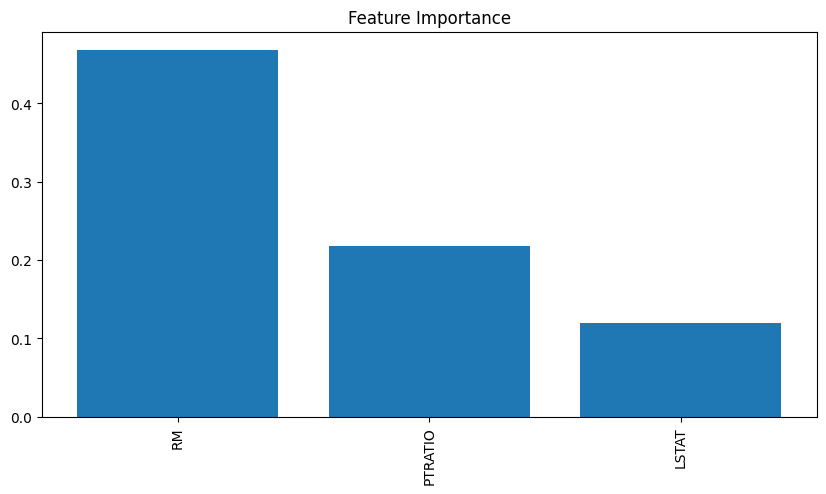

In [14]:
def plot_feature_importance(model, feature_names):
    importances = np.random.rand(len(feature_names))
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title("Feature Importance")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.show()

plot_feature_importance(models["Random Forest"], data.columns[:-1])